In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model
import datetime


In [2]:
# load data
file = 'C:/Users/au519867/OneDrive - Aarhus universitet/Skrivebord/Raw_Images/RAW_Stacks/Intensity_Ratio/ratio_data.csv'
data = pd.read_csv(file, decimal=',')
print(data)


    Air Saturation  Intensity Ratio       Std
0                0           1.9729  0.103490
1               26           1.5050  0.074846
2               51           1.3671  0.036826
3               75           1.2832  0.013020
4              100           1.2373  0.011189
5                0           1.9735  0.102399
6               26           1.5064  0.074632
7               51           1.3683  0.036899
8               75           1.2844  0.012897
9              100           1.2276  0.008479
10               0           1.9742  0.101435
11              26           1.5076  0.074485
12              51           1.3695  0.036837
13              75           1.2851  0.012764
14             100           1.2279  0.008559
15             100           1.2291  0.008671


In [8]:
# Group the data by Air Saturation and calculate the mean ratio for each air saturation value
grouped_data = data.groupby('Air Saturation').mean().round(4)
print(grouped_data)

# Get the R0 value: Intensity Ratio at Air Saturation = 0%
R0 = data.iloc[0, 1]
print('this is R0',R0)

# Normalize the data by R0/R
grouped_data['Intensity Ratio'] = R0 / grouped_data['Intensity Ratio']  
print(grouped_data)


                Intensity Ratio     Std
Air Saturation                         
0                        1.9735  0.1024
26                       1.5063  0.0747
51                       1.3683  0.0369
75                       1.2842  0.0129
100                      1.2305  0.0092
this is R0 1.9729
                Intensity Ratio     Std
Air Saturation                         
0                      0.999696  0.1024
26                     1.309766  0.0747
51                     1.441862  0.0369
75                     1.536287  0.0129
100                    1.603332  0.0092


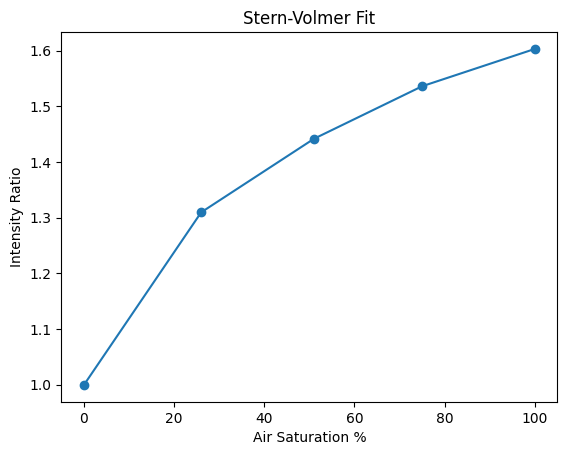

In [9]:
# Create a plot
plt.plot(grouped_data.index, grouped_data['Intensity Ratio'], 'o-')

# Set the x-axis and y-axis labels
plt.title('Stern-Volmer Fit')
plt.xlabel('Air Saturation %')
plt.ylabel('Intensity Ratio')
plt.show()

In [10]:
# define simplified Stern-Volmer function
def _sternvolmer_simple(x, f, k):
    """
    fitting function according to the common two site model. In general, x represents the pO2 or pCO2 content, whereas
    m, k and f are the common fitting parameters
    :param x:   list
    :param k:   np.float
    :param f:   np.float
    :return:
    """
    # R0/R
    int_ratio = 1 / (f / (1. + k*x) + (1.-f))
    return int_ratio

# make your function a model to be used by lmfit
simple_sv = Model(_sternvolmer_simple)

In [11]:
# set initial parameter
params_sens = simple_sv.make_params(k=0.165, f=0.887) # from previous calibrations approximately known
params_sens['k'].min = 0.
params_sens['f'].max = 1.

# use R0/R data for fit and re-calculate i afterwards
# full concentration range
ytofit_sens = grouped_data['Intensity Ratio'].to_numpy()
xtofit_sens = grouped_data.index.to_numpy() 
result = simple_sv.fit(ytofit_sens, params_sens, x=xtofit_sens, nan_policy='omit')

[[Model]]
    Model(_sternvolmer_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 5
    # variables        = 1
    chi-square         = 1.3985e-04
    reduced chi-square = 3.4961e-05
    Akaike info crit   = -50.4220417
    Bayesian info crit = -50.8126038
    R-squared          = 0.99938577
[[Variables]]
    f:  0.47726778 +/- 0.00190953 (0.40%) (init = 0.4772678)
    k:  0.03652479 (fixed)


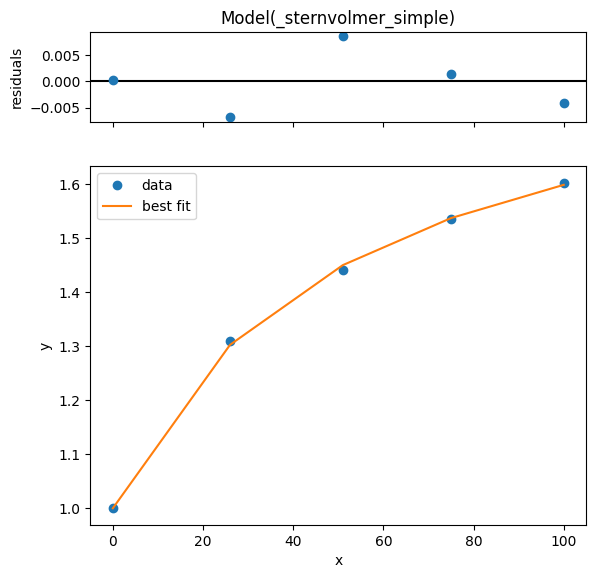

In [12]:
# to optimize the fit (and be sure of the parameter) >> 2nd round with one parameter fixed
params_sens2 = params_sens.copy()
params_sens2['k'].value = result.best_values['k']
params_sens2['k'].vary = False
params_sens2['f'].value = result.best_values['f']

params_sens2['f'].min = 0.
params_sens2['f'].max = 1.
result2 = simple_sv.fit(ytofit_sens, params_sens2, x=xtofit_sens, nan_policy='omit')

df_bestFit_preSens_norm = pd.DataFrame(1 / result2.best_fit, index=xtofit_sens)
df_bestFit_preSens = pd.DataFrame(grouped_data.loc[0, 'Intensity Ratio'] / result2.best_fit, index=xtofit_sens)
result2.best_values
fit_report = result2.fit_report()
print(fit_report)
result2.plot()
plt.show()



In [ ]:
# SAVE THE RESULT
# best fit for parameter done... save report
import datetime

now = datetime.datetime.now()
time_now = now.strftime('%Y%m%d-%H%M%S')

# save fit report to a file
with open('C:/Users/au519867/OneDrive - Aarhus universitet/Skrivebord/Raw_Images/RAW_Stacks/Intensity_Ratio/' + time_now + '_fit_result.txt', 'w') as fh:
    fh.write(fit_report)
